# Try train a convolutional neural network InceptionresnetV2, with dataset contains 433 images.

# Data Preparation

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import glob

# List of dataset

In [ ]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

### Resizing image

In [2]:
IMAGE_SIZE = 224

In [3]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

In [4]:
#reference="https://lxml.de/tutorial.html"
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [5]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [6]:
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars1.xml")

[146, 144, 75, 115]

In [7]:
y[0]

[187, 144, 101, 104]

We check X et y shape

In [8]:
np.array(X).shape

(433, 224, 224, 3)

In [9]:
np.array(y).shape

(433, 4)

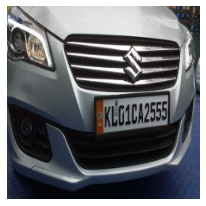

In [11]:
plt.figure(figsize=(20,50))
for i in range(0,1) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

## Using the OpenCV library

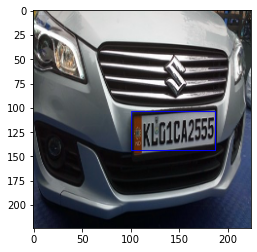

In [12]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


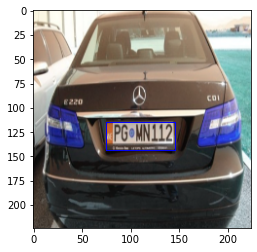

In [15]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


### Prepare the data for the CNN

In [16]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [17]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

# Convolutional Neural Network InceptionResnetV2

In [19]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.inception_resnet_v2 import InceptionResNetV2

In [21]:
# Create the model
model = Sequential()
model.add(InceptionResNetV2(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(64, activation="relu"))

model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 5, 5, 1536)        54336736  
_________________________________________________________________
flatten (Flatten)            (None, 38400)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4915328   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 59,264,740
Trainable params: 4,928,004
No

In [22]:
model.compile(loss='binary_crossentropy', optimizer="adam", metrics=['accuracy'])

In [23]:
train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=150, batch_size=32, verbose=1)

Epoch 1/150
9/9 [==============================] - 5s 586ms/step - loss: 2.2467 - accuracy: 0.4865 - val_loss: 1.2239 - val_accuracy: 0.0000e+00
Epoch 2/150
9/9 [==============================] - 1s 137ms/step - loss: 1.0033 - accuracy: 0.2587 - val_loss: 1.0454 - val_accuracy: 0.5538
Epoch 3/150
9/9 [==============================] - 1s 128ms/step - loss: 0.9115 - accuracy: 0.4788 - val_loss: 0.8389 - val_accuracy: 0.1385
Epoch 4/150
9/9 [==============================] - 1s 131ms/step - loss: 0.8854 - accuracy: 0.4903 - val_loss: 0.7278 - val_accuracy: 0.4923
Epoch 5/150
9/9 [==============================] - 1s 127ms/step - loss: 0.8391 - accuracy: 0.5753 - val_loss: 0.7511 - val_accuracy: 0.5077
Epoch 6/150
9/9 [==============================] - 1s 124ms/step - loss: 0.7529 - accuracy: 0.4865 - val_loss: 0.7404 - val_accuracy: 0.4923
Epoch 7/150
9/9 [==============================] - 1s 125ms/step - loss: 0.7045 - accuracy: 0.5444 - val_loss: 0.7335 - val_accuracy: 0.2615
Epoch 8/1

In [24]:
model.save('model.h5', overwrite=True) 

In [27]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

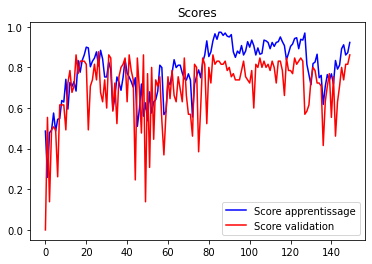

In [28]:
plot_scores(train)

## DETECTION 

In [29]:
test_loss, test_accuracy = model.evaluate(X_test, y_test,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)


 55/100 [===============>..............] - 2s 38ms/step - loss: 0.6539 - accuracy: 0.8073
Test results 
 Loss: 0.6538888812065125 
 Accuracy 0.8073394298553467


In [30]:
 y_cnn = model.predict(X_test)

We can see how our model localize license plates on our testing set :

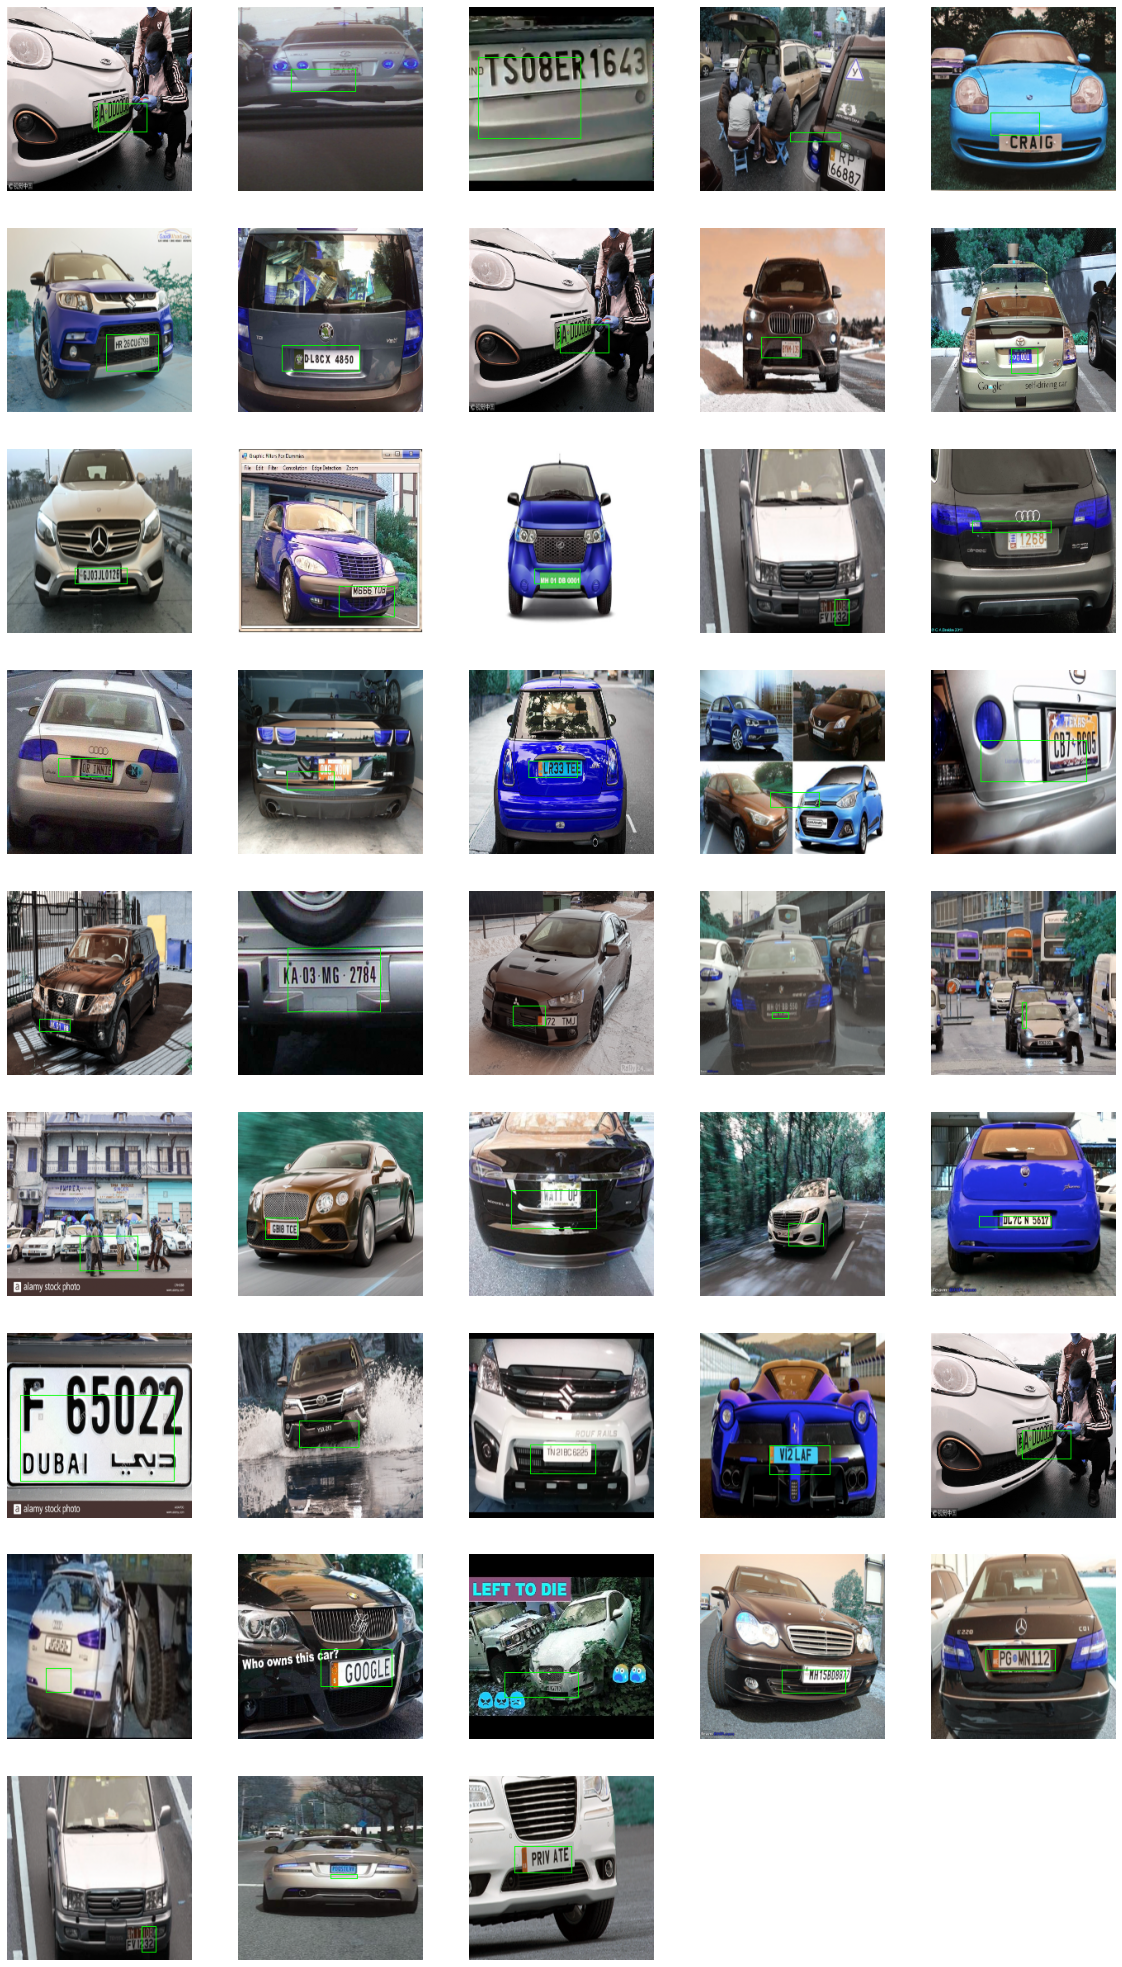

In [31]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]*255
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)



Dataset is the same as Vehicle License Plate Detection | VGG16, but I'm using model VGG19 model

Thanks
Djarot Hindarto
2020101006
Pradita University